[メモ]
- Portfolioの考え方については論文”The value of forecasts_energyfinance”を参照 <p>
 -->ただし、日本の場合はそもそもマーケットの組み合わせによるポートフォリオを組めない<p>
 -->SpotとIntraの組み合わせ比率であれば考えられる
- Trading戦略については、論文"Trading Techniques for European Electricity Markets"を参照

前提 (買い手と売り手の戦略について)
- TraderはPrice-takerであり、Priceに影響を与えないこと
- Spotのオークション戦略は無視 (入札決定後の価格を用いて評価する)
- 価格予測なしでの戦略と価格予測有りでの戦略の違いを明確に分け、パフォーマンスを評価する
- 使用するデータはSpot（System/Tokyo/Tohokuのどれか）, Close Price
- 売買数量については設定できないため、価格の差分のみでリターンとリスクを評価する
- 板情報が入手できないのでアイスバーグ方式は無視(https://www.emsc.meti.go.jp/activity/emsc_system/pdf/051_06_00.pdf P.8)
- 全ての注文は約定できるものと仮定する (インバランスでのペナルティは考慮しない)

評価は、[予測なし]をベンチマークとして[予測有り]のパフォーマンスと比較 <p>
--> Sharp-ratioとVaRを価格リターンから計測する

# Read the dataset

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt #描画ライブラリ
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# import pathlib
# import glob
# import math

# # Show all the rows and columns up to 200
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

In [2]:
#Spot_dataset
df_prediction = pd.read_csv('/Users/kenotsu/Documents/master_thesis/Datasets/Master_thesis/df_prediction.csv', sep=',', header=0)

In [3]:
df_prediction.head()

,Date,HH,date_block_num,Open,High,Low,Close,Spot,DateTime,Close_pred
0,2016-04-01,1,1,7.69,7.69,7.69,7.69,6.61,2016-04-01 00:00:00,5.49
1,2016-04-01,2,1,7.45,7.45,7.45,7.45,6.34,2016-04-01 00:30:00,5.29
2,2016-04-01,3,1,7.21,7.21,7.21,7.21,6.34,2016-04-01 01:00:00,5.27
3,2016-04-01,4,1,7.06,7.06,7.06,7.06,6.25,2016-04-01 01:30:00,5.16
4,2016-04-01,5,1,7.21,7.21,7.21,7.21,6.57,2016-04-01 02:00:00,5.48


# For Seller

トレーディング戦略(売り手: 発電事業者)
[予測なし]
- 100%Spotでの売買を優先 (Spot入札成功率を変えて感度分析)
       -->SpotとIntraのWeightを１００％〜10%で設定する
- 入札漏れは
    -->Closeで成行
    -->Spotの1%, 5%, 10%で指値後、約定しなければCloseで成行

[予測有り]
- Spot価格とIntra予測価格の有利な方で売却 (Spot入札率を変えて感度分析)
- 入札漏れは
    -->予測価格の1%, 5%, 10%で指値後、約定しなければCloseで成行
    
※約定の条件はAsk price < High price

## Required dataset

[現在のデータ]
Spot
Close_pred

[未来のデータ]
Close

### Benchmark

In [4]:
# Set higher price for ask order on benchmark
df_seller_bench = df_prediction.copy()

# Drop Close_pred on benchmark
df_seller_bench = df_seller_bench.drop("Close_pred", axis=1)

# Make Order columns on benchmark
High_list = list(df_seller_bench["High"])
Close_list = list(df_seller_bench["Close"])
# Judge_success = []

# 0%から20%くらいで一旦様子見 (分析次第)
for i in list(range(0, 21, 1)):
# Make Execution columns on benchmark
    Execution_i = []
    Judge_i = []
    Order_list_i = list((df_seller_bench["Spot"]* (1 + i/100)).round(2))
    for o, h, c  in zip(Order_list_i, High_list, Close_list):
        if o <= h:
            Execution_i.append(o)
            Judge_i.append("True")
        else:
            Execution_i.append(c)
            Judge_i.append("False")
    df_seller_bench["Exec_" + str(i) + "%"] = pd.Series(Execution_i)
    df_seller_bench["Judge_" + str(i) + "%"] = pd.Series(Judge_i)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

### Strategy

In [5]:
# Set higher price for ask order on benchmark
df_seller_strategy = df_prediction.copy()

# Make Order columns on benchmark
High_list = list(df_seller_strategy["High"])
Close_list = list(df_seller_strategy["Close"])

# Judge_success = []

# 0%から20%くらいで一旦様子見 (分析次第)
for i in list(range(0, 21, 1)):

# Make Execution columns on benchmark
    Execution_i = []
    Judge_i = []
    Order_list_i = list((df_seller_strategy["Close_pred"]* (1 + i/100)).round(2))
    for o, h, c  in zip(Order_list_i, High_list, Close_list):
        if o <= h:
            Execution_i.append(o)
            Judge_i.append("True")
        else:
            Execution_i.append(c)
            Judge_i.append("False")
    df_seller_strategy["Exec_" + str(i) + "%"] = pd.Series(Execution_i)
    df_seller_strategy["Judge_" + str(i) + "%"] = pd.Series(Judge_i)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

## Construct Portfolios

- Spot と Intraの組み合わせをポートフォリオと捉える
- 以下の戦略について指値+1%, +5%, +10%で構築
    -->10ポートフォリオ×3執行パターン×２(Bench＆Strategy) = 60パターン出来上がる -->ループ必須



1)Weightの設定

2)Excution_bufferの設定

3)Spotのweightを変化させてそれぞれのリターン(差額)を返す

### Benchmark Portfolio

In [6]:
# できればポートフォリオ構築と評価は分けておきたい (ややこしくなるならスキップ)

### Strategy Portfolio

In [7]:
# できればポートフォリオ構築と評価は分けておきたい (ややこしくなるならスキップ)

## Evaluation function

以下の算出式を整理しておく (各戦略の各タイムスロットのポートフォリオ毎に算出する -->タイムスロット分だけポートフォリオができあがる )
- Return = 売却価格 (単純に売るだけだから、タイミングの問題、Spot/Close/Predicted/指値+-a%)
- Standard Deviation = 期間中のStandard deviationを確認
- Sharp-ratio = 上記から算出し、ベンチマークと各戦略の値を比較 -->高いほうが勝ち
- VaR = ？？

※一旦全期間で評価してるけど、年間で分けたほうが良さそう

### Benchmark portfolio

In [8]:
# ここで最終的に欲しいものは上記数値
# Benchmarkのポートフォリオ

Spot_list = list(df_seller_bench["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 21, 1))

# 算出結果を格納するリスト
cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []


for i in execution_buffers:
    Exec_list = list(df_seller_bench["Exec_" + str(i) + "%"]) # Exec_listをexecution_bufferに合わせて再設定
    for weight in portfolio_weights:
        Return = [] #ループ毎にreturnを格納するリストを再設定
        for spot, execution in zip(Spot_list, Exec_list):
            # Spotで全約定した場合、spot*weightをReturn[]に格納していく
            if weight == 1.0:
                #Returnを格納
                Return.append(spot*weight)
                
            #Spotで約定できなかった場合、spot*weight + execution*(1-weight)をReturn[]に格納していく
            else:
                #Returnを格納
                Return.append(spot*weight + execution*(1-weight))

        if weight == 1.0:
            cols.append("Spot" + str(weight*100))
        else:
            cols.append("Spot" + str(weight*100) + "%&Order+" +str(i) + "%")

        #30ポートフォリオの算出結果をリストに格納していく
        Return = pd.Series(Return)
        PortfolioReturn.append(Return.mean().round(2))
        StandardDeviation.append(Return.std().round(2))
        Max.append(Return.max().round(2))
        Min.append(Return.min().round(2))
        SharpRatio.append((Return.mean()/Return.std()).round(2))

#df_portfolio_benchの列を設定し、行列を入替えて調整する
df_portfolio_bench = pd.DataFrame()
df_portfolio_bench = df_portfolio_bench.T

#各算出結果をdf_portfolio_benchの列へ追加する
df_portfolio_bench["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_portfolio_bench["StandardDeviation"] = pd.Series(StandardDeviation)
df_portfolio_bench["Max"] = pd.Series(Max)
df_portfolio_bench["Min"] = pd.Series(Min)
df_portfolio_bench["SharpRatio"] = pd.Series(SharpRatio)
df_portfolio_bench.index = cols

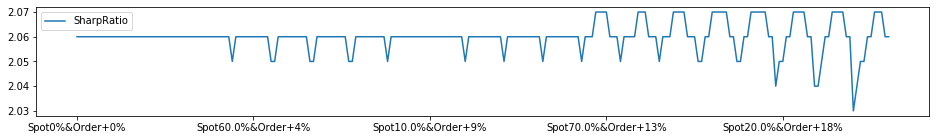

In [9]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
df_portfolio_bench["SharpRatio"].plot()
plt.legend(loc="upper left");

In [10]:
df_portfolio_bench.describe()

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
count,231.000000,231.000000,231.00000,2.310000e+02,231.000000
mean,8.870866,4.308961,84.00000,1.000000e-02,2.059913
std,0.296419,0.147903,3.83104,1.738491e-18,0.005897
min,8.540000,4.150000,80.00000,1.000000e-02,2.030000
25%,8.620000,4.190000,80.84000,1.000000e-02,2.060000
50%,8.790000,4.270000,82.88000,1.000000e-02,2.060000
75%,9.065000,4.400000,86.32000,1.000000e-02,2.060000
max,9.700000,4.780000,96.00000,1.000000e-02,2.070000


In [11]:
df_portfolio_bench[df_portfolio_bench["StandardDeviation"] == 4.66]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
Spot0%&Order+16%,9.55,4.66,92.8,0.01,2.05


In [12]:
df_portfolio_bench[df_portfolio_bench["SharpRatio"] == 2.05]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
Spot0%&Order+4%,8.85,4.31,83.20,0.01,2.05
Spot0%&Order+5%,8.92,4.34,84.00,0.01,2.05
Spot10.0%&Order+5%,8.88,4.32,83.60,0.01,2.05
Spot0%&Order+6%,8.99,4.38,84.80,0.01,2.05
Spot10.0%&Order+6%,8.95,4.36,84.32,0.01,2.05
Spot0%&Order+7%,9.06,4.42,85.60,0.01,2.05
Spot10.0%&Order+7%,9.01,4.39,85.04,0.01,2.05
Spot0%&Order+8%,9.13,4.44,86.40,0.01,2.05
Spot0%&Order+10%,9.25,4.50,88.00,0.01,2.05
Spot0%&Order+11%,9.30,4.53,88.80,0.01,2.05


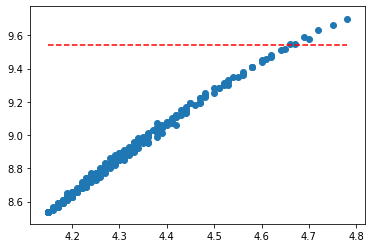

In [13]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.hlines(9.54	, df_portfolio_bench["StandardDeviation"].min(), df_portfolio_bench["StandardDeviation"].max(), label="Minimum risk", linestyle="dashed", color="r")
plt.scatter(x=df_portfolio_bench["StandardDeviation"], y=df_portfolio_bench["PortfolioReturn"])

[Benchmark] <p>
Efficient frontier: PortfolioReturn < 9.54 <p>
Max_SharpRatio = 2.05

### Strategy portfolio

In [14]:
# ここで最終的に欲しいものは上記数値
# Strategyのポートフォリオ

Spot_list = list(df_seller_strategy["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 21, 1))

# 算出結果を格納するリスト
cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []


for i in execution_buffers:
    Exec_list = list(df_seller_strategy["Exec_" + str(i) + "%"]) # Exec_listをexecution_bufferに合わせて再設定
    for weight in portfolio_weights:
        Return = [] #ループ毎にreturnを格納するリストを再設定
        for spot, execution in zip(Spot_list, Exec_list):
            # Spotで全約定した場合、spot*weightをReturn[]に格納していく
            if weight == 1.0:
                #Returnを格納
                Return.append(spot*weight)
            #Spotで約定できなかった場合、spot*weight + execution*(1-weight)をReturn[]に格納していく
            else:
                #Returnを格納
                Return.append(spot*weight + execution*(1-weight))

        if weight == 1.0:
            cols.append("Spot" + str(weight*100))
        else:
            cols.append("Spot" + str(weight*100) + "%&Order+" +str(i) + "%")

        #30ポートフォリオの算出結果をリストに格納していく
        Return = pd.Series(Return)
        PortfolioReturn.append(Return.mean().round(2))
        StandardDeviation.append(Return.std().round(2))
        Max.append(Return.max().round(2))
        Min.append(Return.min().round(2))
        SharpRatio.append((Return.mean()/Return.std()).round(2))


#df_portfolio_benchの列を設定し、行列を入替えて調整する
df_seller_strategy = pd.DataFrame()
df_seller_strategy = df_seller_strategy.T

#各算出結果をdf_portfolio_benchの列へ追加する
df_seller_strategy["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_seller_strategy["StandardDeviation"] = pd.Series(StandardDeviation)
df_seller_strategy["Max"] = pd.Series(Max)
df_seller_strategy["Min"] = pd.Series(Min)
df_seller_strategy["SharpRatio"] = pd.Series(SharpRatio)
df_seller_strategy.index = cols

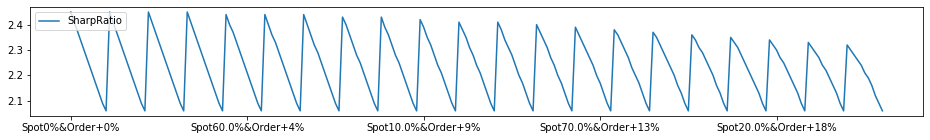

In [15]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
df_seller_strategy["SharpRatio"].plot()
plt.legend(loc="upper left");

In [16]:
df_seller_strategy.describe()

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
count,231.000000,231.000000,231.000000,231.000000,231.000000
mean,8.820996,3.953896,72.673723,0.124935,2.234935
std,0.291063,0.174212,4.503940,0.074372,0.112210
min,8.390000,3.420000,61.590000,0.010000,2.060000
25%,8.580000,3.850000,69.535000,0.060000,2.130000
50%,8.740000,4.000000,72.910000,0.120000,2.240000
75%,9.010000,4.100000,76.015000,0.190000,2.330000
max,9.660000,4.160000,80.000000,0.260000,2.450000


In [17]:
df_seller_strategy[df_seller_strategy["StandardDeviation"] == 3.34]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


In [18]:
df_seller_strategy[df_seller_strategy["SharpRatio"] == 2.51]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


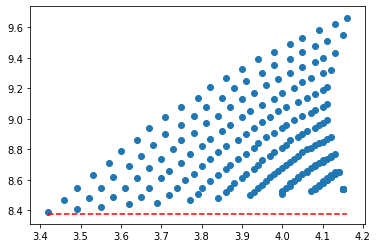

In [19]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.hlines(8.38	, df_seller_strategy["StandardDeviation"].min(), df_seller_strategy["StandardDeviation"].max(), label="Minimum risk", linestyle="dashed", color="r")
plt.scatter(x=df_seller_strategy["StandardDeviation"], y=df_seller_strategy["PortfolioReturn"])

Efficient frontier: PortfolioReturn < 8.38 <p>
Max_SharpRatio = 2.51
    
※課題
- 各年での評価がまだできていない (ポートフォリオ構築からやり直す必要があるかも。例えば元のテーブルでポートフォリオ構築まで組み込んで、評価テーブルで各商品ごとの集計に切り替える、等)
- 各商品のポートフォリオ比率が一定 --> (各商品ごとに最適なポートフォリオを選択するという手段もある)


※アイディア案
- 各商品別にポートフォリオを組んで別テーブルを作る (行：各商品、時系列順　　列：各条件のポートフォリオ)
- 横軸で(各商品ごとに)Maxの数値を選択しMix　portfolioも加える
- Mix　Portfolioも加えて各年で分けて評価していく
- 最終的な評価はTrain期間とValid期間を分けて実施したいところ

# For Buyer

トレーディング戦略(買い手：小売)
[予測なし(ベンチマーク)]
- 100%Spotでの売買を優先 (Spot入札成功率を変えて感度分析)
       -->SpotとIntraのWeightを１００％〜10%で設定する
- 入札漏れは
    -->Closeで成行
    -->Spotの1%, 5%, 10%で指値後、約定しなければCloseで成行

[予測有り]
- Spot価格とIntra予測価格の有利な方で売却 (Spot入札率を変えて感度分析)
- 入札漏れは
    -->予測価格の1%, 5%, 10%で指値後、約定しなければCloseで成行
    
※約定の条件はBid price > Low price

## Requierd dataset

### Benchmark

In [20]:
# Set higher price for ask order on benchmark
df_buyer_bench = df_prediction.copy()

# Drop Close_pred on benchmark
df_buyer_bench = df_buyer_bench.drop("Close_pred", axis=1)

# Make Order columns on benchmark
Low_list = list(df_buyer_bench["Low"])
Close_list = list(df_buyer_bench["Close"])
# Judge_success = []

# 0%から20%くらいで一旦様子見 (分析次第)
for i in list(range(0, 21, 1)):
# Make Execution columns on benchmark
    Execution_i = []
    Judge_i = []
    Order_list_i = list((df_buyer_bench["Spot"]* (1 -  i/100)).round(2))
    for o, l, c  in zip(Order_list_i, Low_list, Close_list):
        if o >= l:
            Execution_i.append(o)
            Judge_i.append("True")
        else:
            Execution_i.append(c)
            Judge_i.append("False")
    df_buyer_bench["Exec_" + str(i) + "%"] = pd.Series(Execution_i)
    df_buyer_bench["Judge_" + str(i) + "%"] = pd.Series(Judge_i)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

In [21]:
df_buyer_bench.head()

,Date,HH,date_block_num,Open,High,Low,Close,Spot,DateTime,Exec_0%,...,Exec_16%,Judge_16%,Exec_17%,Judge_17%,Exec_18%,Judge_18%,Exec_19%,Judge_19%,Exec_20%,Judge_20%
0,2016-04-01,1,1,7.69,7.69,7.69,7.69,6.61,2016-04-01 00:00:00,7.69,...,7.69,False,7.69,False,7.69,False,7.69,False,7.69,False
1,2016-04-01,2,1,7.45,7.45,7.45,7.45,6.34,2016-04-01 00:30:00,7.45,...,7.45,False,7.45,False,7.45,False,7.45,False,7.45,False
2,2016-04-01,3,1,7.21,7.21,7.21,7.21,6.34,2016-04-01 01:00:00,7.21,...,7.21,False,7.21,False,7.21,False,7.21,False,7.21,False
3,2016-04-01,4,1,7.06,7.06,7.06,7.06,6.25,2016-04-01 01:30:00,7.06,...,7.06,False,7.06,False,7.06,False,7.06,False,7.06,False
4,2016-04-01,5,1,7.21,7.21,7.21,7.21,6.57,2016-04-01 02:00:00,7.21,...,7.21,False,7.21,False,7.21,False,7.21,False,7.21,False


### Strategy

In [22]:
# Set higher price for ask order on benchmark
df_buyer_strategy = df_prediction.copy()

# Make Order columns on benchmark
Low_list = list(df_buyer_strategy["Low"])
Close_list = list(df_buyer_strategy["Close"])

# Judge_success = []

# 0%から20%くらいで一旦様子見 (分析次第)
for i in list(range(0, 21, 1)):

# Make Execution columns on benchmark
    Execution_i = []
    Judge_i = []
    Order_list_i = list((df_buyer_strategy["Close_pred"]* (1 - i/100)).round(2))
    for o, l, c  in zip(Order_list_i, Low_list, Close_list):
        if o >= l:
            Execution_i.append(o)
            Judge_i.append("True")
        else:
            Execution_i.append(c)
            Judge_i.append("False")
    df_buyer_strategy["Exec_" + str(i) + "%"] = pd.Series(Execution_i)
    df_buyer_strategy["Judge_" + str(i) + "%"] = pd.Series(Judge_i)

#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

In [23]:
df_buyer_strategy.head()

,Date,HH,date_block_num,Open,High,Low,Close,Spot,DateTime,Close_pred,...,Exec_16%,Judge_16%,Exec_17%,Judge_17%,Exec_18%,Judge_18%,Exec_19%,Judge_19%,Exec_20%,Judge_20%
0,2016-04-01,1,1,7.69,7.69,7.69,7.69,6.61,2016-04-01 00:00:00,5.49,...,7.69,False,7.69,False,7.69,False,7.69,False,7.69,False
1,2016-04-01,2,1,7.45,7.45,7.45,7.45,6.34,2016-04-01 00:30:00,5.29,...,7.45,False,7.45,False,7.45,False,7.45,False,7.45,False
2,2016-04-01,3,1,7.21,7.21,7.21,7.21,6.34,2016-04-01 01:00:00,5.27,...,7.21,False,7.21,False,7.21,False,7.21,False,7.21,False
3,2016-04-01,4,1,7.06,7.06,7.06,7.06,6.25,2016-04-01 01:30:00,5.16,...,7.06,False,7.06,False,7.06,False,7.06,False,7.06,False
4,2016-04-01,5,1,7.21,7.21,7.21,7.21,6.57,2016-04-01 02:00:00,5.48,...,7.21,False,7.21,False,7.21,False,7.21,False,7.21,False


## Construct Portfolios

- Spot と Intraの組み合わせをポートフォリオと捉える
- 以下の戦略について指値 -α %で構築
    -->10ポートフォリオ×20執行パターン×２(Bench＆Strategy) = 200パターン出来上がる -->ループ必須


1)Weightの設定

2)Excution_bufferの設定

3)Spotのweightを変化させてそれぞれのリターン(差額)を返す

### Benchmark Portfolio

In [24]:
# できればポートフォリオ構築と評価は分けておきたい (ややこしくなるならスキップ)

### Strategy Portfolio

In [25]:
# できればポートフォリオ構築と評価は分けておきたい (ややこしくなるならスキップ)

## Evaluation function

以下の算出式を整理しておく
- Return = 買取価格 (単純に買うだけだから、タイミングの問題、Spot/Close/Predicted/指値+-a%)
- Standard Deviation = 期間中のStandard deviationを確認
- Sharp-ratio = 上記から算出し、ベンチマークと各戦略の値を比較 -->安いほうが勝ち
- VaR = ？？

※一旦全期間で評価してるけど、年間で分けたほうが良さそう

### Benchmark portfolio

In [26]:
# ここで最終的に欲しいものは上記数値
# Benchmarkのポートフォリオ

Spot_list = list(df_buyer_bench["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 21, 1))

# 算出結果を格納するリスト
cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []


for i in execution_buffers:
    Exec_list = list(df_buyer_bench["Exec_" + str(i) + "%"]) # Exec_listをexecution_bufferに合わせて再設定
    for weight in portfolio_weights:
        Return = [] #ループ毎にreturnを格納するリストを再設定
        for spot, execution in zip(Spot_list, Exec_list):
            # Spotで全約定した場合、spot*weightをReturn[]に格納していく
            if weight == 1.0:
                #Returnを格納
                Return.append(spot*weight)
            #Spotで約定できなかった場合、spot*weight + execution*(1-weight)をReturn[]に格納していく
            else:
                #Returnを格納
                Return.append(spot*weight + execution*(1-weight))

        if weight == 1.0:
            cols.append("Spot" + str(weight*100))
        else:
            cols.append("Spot" + str(weight*100) + "%&Order+" +str(i) + "%")

        #30ポートフォリオの算出結果をリストに格納していく
        Return = pd.Series(Return)
        PortfolioReturn.append(Return.mean().round(2))
        StandardDeviation.append(Return.std().round(2))
        Max.append(Return.max().round(2))
        Min.append(Return.min().round(2))
        SharpRatio.append((Return.mean()/Return.std()).round(2))


#df_portfolio_benchの列を設定し、行列を入替えて調整する
df_portfolio_bench = pd.DataFrame()
df_portfolio_bench = df_portfolio_bench.T

#各算出結果をdf_portfolio_benchの列へ追加する
df_portfolio_bench["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_portfolio_bench["StandardDeviation"] = pd.Series(StandardDeviation)
df_portfolio_bench["Max"] = pd.Series(Max)
df_portfolio_bench["Min"] = pd.Series(Min)
df_portfolio_bench["SharpRatio"] = pd.Series(SharpRatio)
df_portfolio_bench.index = cols

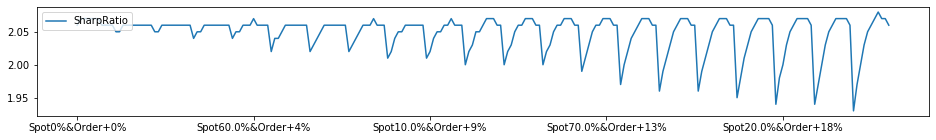

In [27]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
df_portfolio_bench["SharpRatio"].plot()
plt.legend(loc="upper left");

In [28]:
df_portfolio_bench.describe()

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
count,231.000000,231.000000,231.000000,2.310000e+02,231.000000
mean,8.337662,4.070909,102.411342,1.000000e-02,2.048139
std,0.200236,0.062842,24.360176,1.738491e-18,0.027481
min,7.830000,3.960000,78.560000,1.000000e-02,1.930000
25%,8.200000,4.010000,79.680000,1.000000e-02,2.050000
50%,8.390000,4.070000,98.520000,1.000000e-02,2.060000
75%,8.510000,4.130000,121.345000,1.000000e-02,2.060000
max,8.630000,4.190000,150.000000,1.000000e-02,2.080000


In [29]:
df_portfolio_bench[df_portfolio_bench["StandardDeviation"] == 4.41]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


In [30]:
df_portfolio_bench[df_portfolio_bench["SharpRatio"] == 1.87]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


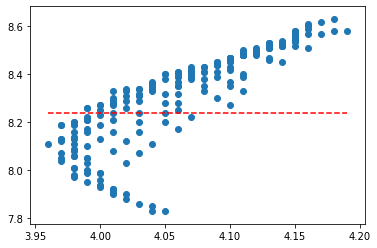

In [31]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.hlines(8.24, df_portfolio_bench["StandardDeviation"].min(), df_portfolio_bench["StandardDeviation"].max(), label="Minimum risk", linestyle="dashed", color="r")
plt.scatter(x=df_portfolio_bench["StandardDeviation"], y=df_portfolio_bench["PortfolioReturn"])

[Benchmark] Buyerのケースのリターンについてはもう少し検討が必要<p>
    
Efficient frontier: PortfolioReturn < 8.24 <p>
Min_SharpRatio = 1.87

### Strategy portfolio

In [32]:
# ここで最終的に欲しいものは上記数値
# Strategyのポートフォリオ

Spot_list = list(df_buyer_strategy["Spot"])

portfolio_weights= [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
execution_buffers = list(range(0, 21, 1))

# 算出結果を格納するリスト
cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []


for i in execution_buffers:
    Exec_list = list(df_buyer_strategy["Exec_" + str(i) + "%"]) # Exec_listをexecution_bufferに合わせて再設定
    for weight in portfolio_weights:
        Return = [] #ループ毎にreturnを格納するリストを再設定
        for spot, execution in zip(Spot_list, Exec_list):
            # Spotで全約定した場合、spot*weightをReturn[]に格納していく
            if weight == 1.0:
                #Returnを格納
                Return.append(spot*weight)
            #Spotで約定できなかった場合、spot*weight + execution*(1-weight)をReturn[]に格納していく
            else:
                #Returnを格納
                Return.append(spot*weight + execution*(1-weight))

        if weight == 1.0:
            cols.append("Spot" + str(weight*100))
        else:
            cols.append("Spot" + str(weight*100) + "%&Order+" +str(i) + "%")

        #30ポートフォリオの算出結果をリストに格納していく
        Return = pd.Series(Return)
        PortfolioReturn.append(Return.mean().round(2))
        StandardDeviation.append(Return.std().round(2))
        Max.append(Return.max().round(2))
        Min.append(Return.min().round(2))
        SharpRatio.append((Return.mean()/Return.std()).round(2))


#df_portfolio_benchの列を設定し、行列を入替えて調整する
df_buyer_strategy = pd.DataFrame()
df_buyer_strategy = df_buyer_strategy.T

#各算出結果をdf_portfolio_benchの列へ追加する
df_buyer_strategy["PortfolioReturn"] = pd.Series(PortfolioReturn)
df_buyer_strategy["StandardDeviation"] = pd.Series(StandardDeviation)
df_buyer_strategy["Max"] = pd.Series(Max)
df_buyer_strategy["Min"] = pd.Series(Min)
df_buyer_strategy["SharpRatio"] = pd.Series(SharpRatio)
df_buyer_strategy.index = cols

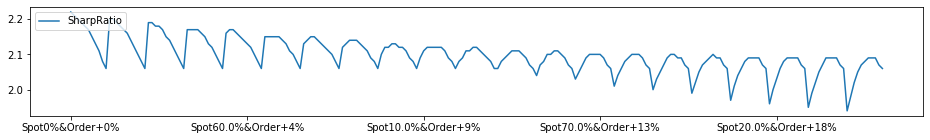

In [33]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.05))
df_buyer_strategy["SharpRatio"].plot()
plt.legend(loc="upper left");

In [34]:
df_buyer_strategy.describe()

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio
count,231.000000,231.000000,231.000000,231.000000,231.000000
mean,8.255152,3.936797,104.698182,0.104329,2.097489
std,0.232092,0.108476,25.222987,0.060010,0.047234
min,7.710000,3.790000,78.950000,0.010000,1.940000
25%,8.085000,3.850000,79.650000,0.050000,2.070000
50%,8.300000,3.910000,98.520000,0.110000,2.090000
75%,8.460000,4.020000,129.410000,0.150000,2.120000
max,8.540000,4.150000,150.000000,0.220000,2.220000


In [35]:
df_buyer_strategy[df_buyer_strategy["StandardDeviation"] == 3.77]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


In [36]:
df_buyer_strategy[df_buyer_strategy["SharpRatio"] == 1.91]

,PortfolioReturn,StandardDeviation,Max,Min,SharpRatio


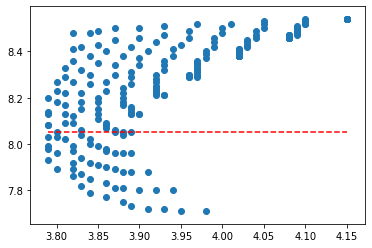

In [37]:
# fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
plt.hlines(8.05, df_buyer_strategy["StandardDeviation"].min(), df_buyer_strategy["StandardDeviation"].max(), label="Minimum risk", linestyle="dashed", color="r")
plt.scatter(x=df_buyer_strategy["StandardDeviation"], y=df_buyer_strategy["PortfolioReturn"])

Efficient frontier: PortfolioReturn < 8.05 <p>
Min_SharpRatio = 1.91
    
※課題
- 各年での評価がまだできていない (ポートフォリオ構築からやり直す必要があるかも。例えば元のテーブルでポートフォリオ構築まで組み込んで、評価テーブルで各商品ごとの集計に切り替える、等)
- 各商品のポートフォリオ比率が一定 --> (各商品ごとに最適なポートフォリオを選択するという手段もある)


※アイディア案
- 各商品別にポートフォリオを組んで別テーブルを作る (行：各商品、時系列順　　列：各条件のポートフォリオ)
- 横軸で(各商品ごとに)Minの数値を選択しMix　portfolioも加える
- Mix　Portfolioも加えて各年で分けて評価していく

# For Trader

前提（トレーダー）
- 下記裁定トレーディングを実施するためには、EMHの仮定を棄却する必要がある
- そのためには各商品の自己相関を確認しておく　-->価格予測Noteの "Close priceのEDAパートもしくはSARIMAパート"参照
-　Spotで買い/売りを仕掛け、Intraで全ポジション反対決裁 --> 取引数量は無視 (1単位のみ)
- 手仕舞い時のみ指値を活用

- 論文では　"combination of the GARCH and Ljung-Box methods"で2015年のSpot, Intra priceを両方検証し、棄却に成功している(４タイムスロットの日足データ)<p>
    -->各タイムスロットの年間のデータはSpotもIntraも入手可能<p>
    -->ただ、１年間のみ４スロットの検証で事足りるのか？？<p>
    -->他に考えられる検証はないか。。。？<p>


- JEPXの取引フローを調べておく (論文では約定フローとルールについて図解してある)
- 論文では単純にSpotとIntraの価格差を損益として、年間の取引数Nを集計ししている

トレーディング戦略(トレーダーの戦略について)
[予測なし]
予測なしではこの戦略は取れないので不要

[予測有り]
- Spot/Intra価格差に対して裁定取引をする(IntraではClose_predの+-α%感度分析)

(Reference) 
オリジナリティが強すぎるのでなにか参考文献を見つけておく

"Speculative Trading and Market Performance: The Effect of Arbitrageurs on Efficiency and Market Power in the New York Electricity Market (2003)"
https://escholarship.org/content/qt0mx44472/qt0mx44472_noSplash_3bb91c9ed710e4c77dffa5caf1a6512b.pdf?t=krnn5f

## Required dataset

In [38]:
# Set higher price for ask order on benchmark
df_trader = df_prediction.copy()

# Make Order columns on benchmark
High_list = list(df_trader["High"])
Low_list = list(df_trader["Low"])
Close_list = list(df_trader["Close"])

# Judge_success = []

# 0%から20%くらいで一旦様子見 (分析次第)
for i in list(range(0, 21, 1)):

# Make BuyPositioin columns
    Buy_i = []
    BuyJudge_i = []
    BuyPositon_i = list((df_trader["Close_pred"]* (1 - i/100)).round(2))
    for o, l, c  in zip(BuyPositon_i, Low_list, Close_list):
        #約定できるケース --> BuyPositon_i
        if o >= l:
            Buy_i.append(o)
            BuyJudge_i.append("True")
        #約定できないケース -->Close
        else:
            Buy_i.append(c)
            BuyJudge_i.append("False")
    df_trader["Buy-" + str(i) + "%"] = pd.Series(Buy_i)
    df_trader["BuyJudge_" + str(i) + "%"] = pd.Series(BuyJudge_i)

    # Make SellPosition columns
    Sell_i = []
    SellJudge_i = []
    SellPositon_i = list((df_trader["Close_pred"]* (1 + i/100)).round(2))
    for o, h, c  in zip(SellPositon_i, High_list, Close_list):
        if o <= h:
            Sell_i.append(o)
            SellJudge_i.append("True")
        else:
            Sell_i.append(c)
            SellJudge_i.append("False")
    df_trader["Sell+" + str(i) + "%"] = pd.Series(Sell_i)
    df_trader["Judge_" + str(i) + "%"] = pd.Series(SellJudge_i)

    
#     Judge_success.append((df_seller_bench["Judge_" + str(i) + "%"] == 'True').sum())
# #For graph
# Judge_success = pd.Series(Judge_success)

In [39]:
df_trader.head()

,Date,HH,date_block_num,Open,High,Low,Close,Spot,DateTime,Close_pred,...,Sell+18%,Judge_18%,Buy-19%,BuyJudge_19%,Sell+19%,Judge_19%,Buy-20%,BuyJudge_20%,Sell+20%,Judge_20%
0,2016-04-01,1,1,7.69,7.69,7.69,7.69,6.61,2016-04-01 00:00:00,5.49,...,6.48,True,7.69,False,6.53,True,7.69,False,6.59,True
1,2016-04-01,2,1,7.45,7.45,7.45,7.45,6.34,2016-04-01 00:30:00,5.29,...,6.24,True,7.45,False,6.30,True,7.45,False,6.35,True
2,2016-04-01,3,1,7.21,7.21,7.21,7.21,6.34,2016-04-01 01:00:00,5.27,...,6.22,True,7.21,False,6.27,True,7.21,False,6.32,True
3,2016-04-01,4,1,7.06,7.06,7.06,7.06,6.25,2016-04-01 01:30:00,5.16,...,6.09,True,7.06,False,6.14,True,7.06,False,6.19,True
4,2016-04-01,5,1,7.21,7.21,7.21,7.21,6.57,2016-04-01 02:00:00,5.48,...,6.47,True,7.21,False,6.52,True,7.21,False,6.58,True


## Construct Portfolios

売買戦略は以下の通り <p>
- まずは基本的なSpotとIntra間のアビトラから組んでみる(指値バッファ0%のポートフォリオが１つ出来上がる)
- 次に可能であれば指値バッファを変化させてポートフォリオを増やしていく<p>
    --> 指値バッファが変わることで損益が大きく変わるはず

## Evaluation function

以下の算出式を整理しておく (基本的にはベース論文を参考にする)
- Return = 各48商品の| Pintra_actual - Pspot |についての合計

- Standard Deviation
    -->Intra priceとSpot priceのStandard deviationを算出し、Weightに応じて算出
 
- Sharp-ratio
    -->上記RerurnとStandard deviationから算出する -->超過リターンを計測し、トレーディングの可能性を示す
    
- VaR　=[Expected Weighted Return of the Portfolio − (z-score of the confidence interval × standard deviation of the portfolio)] × portfolio value

-->Required datasetに上記結果を追加する
-->48商品を横軸、年月日を縦軸のテーブル、値に評価関数を当てはめて期間集計し、それぞれ列を追加する
-->線グラフ化で推移を確認
-->リターンの分布を確認できる (テールリスクについてもざっくり見られる)
-->テールリスクについてはVaRで掘り下げていく

[VaRの考え方について]


評価と評価期間
- ベンチマークと各戦略の年間収益額を算出
- グラフで比較

In [41]:
#Tradingのポートフォリオ

Spot_list = list(df_trader["Spot"])
Pred_list = list(df_trader["Close_pred"])
Close_list = list(df_trader["Close"])
High_list = list(df_trader["High"])
Low_list = list(df_trader["Low"])

# 算出結果を格納するリスト
cols = []

Return = [] 
PortfolioReturn = []
StandardDeviation = []
Max = []
Min = []
SharpRatio = []


#一旦は指値バッファなしで組んでみる
for spot, pred, high, low, close in zip(Spot_list, Pred_list, High_list, Low_list, Close_list):
    #　Buy-in, Sell-out
    if spot < pred:
        #Returnを格納
        #約定成功
        if pred < high:
            Return.append(round(pred - spot, 4))
        #約定失敗
        else:
            Return.append(round(close - spot, 4))
            
    # Sell-in, Buy-out
    elif spot > pred:
        #Returnを格納
        #約定成功
        if pred > low:
            Return.append(round(spot - pred, 4))
        #約定失敗
        else:
            Return.append(round(spot - close, 4))
    #No trade
    else:
        Return.append(0)

# if weight == 1.0:
#     cols.append("Spot" + str(weight*100))
# else:
#     cols.append("Spot" + str(weight*100) + "%&Order+" +str(i) + "%")


df_trader_portfolio = pd.DataFrame()
df_trader_portfolio["Date"] = df_trader["Date"]
df_trader_portfolio["HH"] = df_trader["HH"]
df_trader_portfolio["Return"] = pd.Series(Return)
# #30ポートフォリオの算出結果をリストに格納していく
# Return = pd.Series(Return)
# PortfolioReturn.append(Return.mean().round(2))
# StandardDeviation.append(Return.std().round(2))
# Max.append(Return.max().round(2))
# Min.append(Return.min().round(2))
# SharpRatio.append((Return.mean()/Return.std()).round(2))


# #df_portfolio_benchの列を設定し、行列を入替えて調整する
# df_buyer_strategy = pd.DataFrame()
# df_buyer_strategy = df_buyer_strategy.T

# #各算出結果をdf_portfolio_benchの列へ追加する
# df_buyer_strategy["PortfolioReturn"] = pd.Series(PortfolioReturn)
# df_buyer_strategy["StandardDeviation"] = pd.Series(StandardDeviation)
# df_buyer_strategy["Max"] = pd.Series(Max)
# df_buyer_strategy["Min"] = pd.Series(Min)
# df_buyer_strategy["SharpRatio"] = pd.Series(SharpRatio)
# df_buyer_strategy.index = cols

In [42]:
df_trader_portfolio.head()

,Date,HH,Return
0,2016-04-01,1,-1.08
1,2016-04-01,2,-1.11
2,2016-04-01,3,-0.87
3,2016-04-01,4,-0.81
4,2016-04-01,5,-0.64


In [43]:
#valuesの値を変えれば別のポートフォリオの集計もできる
df_trader_portfolio_table = pd.DataFrame(df_trader_portfolio.pivot(index='Date', columns='HH', values='Return'))

In [44]:
df_trader_portfolio_table["Expected_Return"] = df_trader_portfolio_table.loc[: , 0:48].mean(axis=1).round(2)
df_trader_portfolio_table["StandardDeviation"] = df_trader_portfolio_table.loc[: , 1:48].std(axis=1).round(2)
df_trader_portfolio_table["Max"] = df_trader_portfolio_table.loc[: , 1:48].max(axis=1).round(2)
df_trader_portfolio_table["Min"] = df_trader_portfolio_table.loc[: , 1:48].min(axis=1).round(2)
df_trader_portfolio_table["SharpRatio"] = (df_trader_portfolio_table.loc[: , 1:48].mean(axis=1)/df_trader_portfolio_table.loc[: , 1:48].std(axis=1)).round(2)

In [45]:
df_trader_portfolio_table.head()

HH,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,Expected_Return,StandardDeviation,Max,Min,SharpRatio
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,-1.0800,-1.11,-0.8700,-0.81,-0.640,-0.64,-0.64,-0.64,-0.49,-0.49,...,-0.72,-0.88,-0.91,-1.10,-1.17,-0.37,1.32,1.83,-3.77,-0.28
2016-04-02,0.2400,-0.24,0.1586,0.30,0.270,0.30,0.27,0.26,0.34,0.30,...,0.09,-1.09,-1.04,-0.41,-1.09,0.02,0.51,0.57,-1.09,0.05
2016-04-03,-0.1133,0.76,0.5900,0.56,0.820,1.06,0.85,1.06,1.02,1.05,...,0.20,0.43,0.54,0.42,0.14,0.49,0.30,1.06,-0.11,1.62
2016-04-04,-0.0537,0.59,0.2487,0.01,0.005,0.00,0.05,0.06,0.21,0.18,...,-0.50,0.01,0.29,0.01,0.01,0.21,0.53,1.08,-1.77,0.39
2016-04-05,0.6700,0.64,0.5700,0.44,0.340,0.39,0.41,0.42,0.43,0.40,...,0.20,0.33,-0.65,0.42,0.42,0.67,0.51,1.41,-1.25,1.31


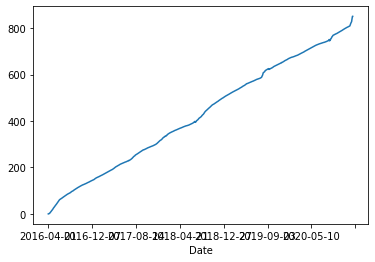

In [46]:
df_trader_portfolio_table['CumReturn'] = df_trader_portfolio_table['Expected_Return'].cumsum()
df_trader_portfolio_table['CumReturn'].plot()

In [47]:
risk = pd.DataFrame(df_trader_portfolio_table['Expected_Return'])
risk

,Expected_Return
Date,
2016-04-01,-0.37
2016-04-02,0.02
2016-04-03,0.49
2016-04-04,0.21
2016-04-05,0.67
...,...
2020-12-27,3.87
2020-12-28,4.96
2020-12-29,3.90


以下ドローダウンを見てみる

In [48]:
risk = pd.DataFrame(df_trader_portfolio_table['Expected_Return'])
risk["equity"] = risk['Expected_Return'].cumsum()
risk["cummax"] = risk["equity"].cummax()
risk["drawdown"] = risk["cummax"] -risk["equity"]

In [49]:
risk["drawdown"].max()

5.899999999999977

In [50]:
t_max = risk["drawdown"].idxmax()
t_max

'2020-08-21'

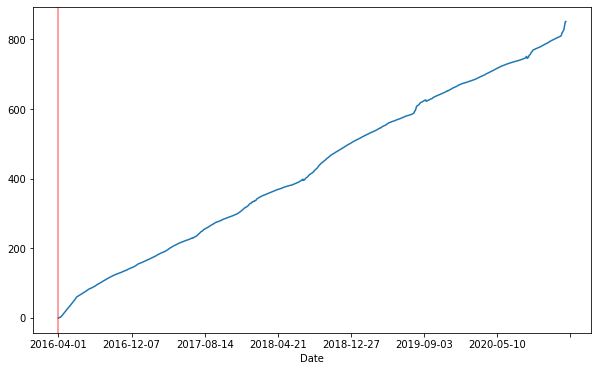

In [51]:
risk["equity"].plot(figsize=(10, 6))
plt.axvline(t_max, c="r", alpha=0.5);

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 9.000e+00,
        1.960e+02, 1.194e+03, 2.280e+02, 5.700e+01, 2.000e+01, 6.000e+00,
        8.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-4.53 , -4.162, -3.794, -3.426, -3.058, -2.69 , -2.322, -1.954,
        -1.586, -1.218, -0.85 , -0.482, -0.114,  0.254,  0.622,  0.99 ,
         1.358,  1.726,  2.094,  2.462,  2.83 ,  3.198,  3.566,  3.934,
         4.302,  4.67 ,  5.038,  5.406,  5.774,  6.142,  6.51 ]),
 <a list of 30 Patch objects>)

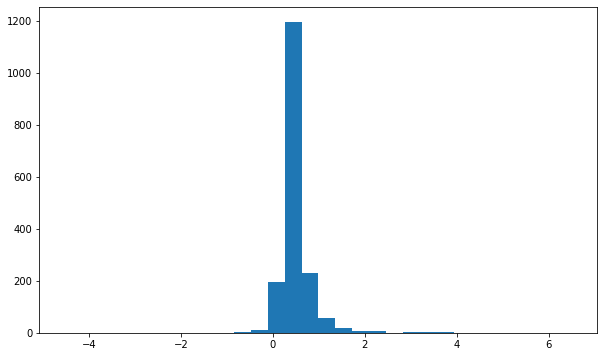

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(risk['Expected_Return'], bins=30)

上記要調整

以下でVaRを算出

In [53]:
import scipy.stats as scs

equity = 1000

percs = np.array([0.01, 0.1, 1., 2.5, 5.0, 10.0])
risk["returns"] = np.log(risk["equity"] / risk["equity"].shift(1))
VaR = scs.scoreatpercentile(equity * risk["returns"], percs)
def print_var():
    print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
    print(43 * '-')
    for pair in zip(percs, VaR):
        print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

In [54]:
print_var()

Confidence Level    Value-at-Risk
-------------------------------------------
           99.99          143.963
           99.90           21.211
           99.00            0.238
           97.50           -0.272
           95.00           -0.338
           90.00           -0.415


VaRに関しては以下のリンクを参考にもう少し他の実装方法も試してみる

[エンジニアのための金融工学入門：Value At Risk(バリューアットリスク）]


https://recruit.gmo.jp/engineer/jisedai/blog/financial_technology_value_at_risk/

一旦は指値バッファなしでテーブル作成。複数のポートフォリオを作ったら、Returnを差し替えて複数のテーブルを作成し、各集計を使って分析していく